# Downloading Images

The `ImageDownloadApi` class in the AllenSDK provides a Python interface for accessing image data produced by the Allen Institute for Brain Science. 

Contents:
* <a href='#Downloading-a-single-Mouse-Brain-Section-image'>Downloading a single Mouse Brain section image</a>
* <a href='#Downloading-a-single-Mouse-Connectivity-image'>Downloading a single Mouse Connectivity section image</a>
* <a href='#Downloading-a-single-atlas-image'>Downloading a single atlas image</a>
* <a href='#Downloading-a-single-atlas-svg'>Downloading a single atlas svg</a>
* <a href='#Listing-images-from-an-atlas-(or-section-data-set)'>Listing images from an atlas or section data set</a>
* <a href='#Downloading-all-of-the-images-from-a-section-data-set'>Downloading all of the images from a section data set</a>

Reference Documentation:
* <a href='http://help.brain-map.org/display/api/Downloading+an+Image'>how to download an image using the API</a>
* <a href='http://allensdk.readthedocs.io/en/latest/allensdk.api.queries.html#module-allensdk.api.queries.image_download_api'>image_download_api module reference</a>
* <a href='http://help.brain-map.org/display/api/Atlas+Drawings+and+Ontologies'>list of atlases, with IDs</a>

Download this file in .ipynb format <a href='image_download.ipynb'>here</a>.

In [45]:
from allensdk.api.queries.image_download_api import ImageDownloadApi
from allensdk.api.queries.svg_api import SvgApi
from allensdk.config.manifest import Manifest

import matplotlib.pyplot as plt
from skimage.io import imread
import pandas as pd
from pathlib import Path

import logging
import os
from base64 import b64encode

from IPython.display import HTML, display
%matplotlib inline

We will want to look at the images we download in this notebook. Here are a couple of functions that do this:

In [46]:
def verify_image(file_path, figsize=(18, 22)):
    image = imread(file_path)

    fig, ax = plt.subplots(figsize=figsize)
    ax.imshow(image)
    
    
def verify_svg(file_path, width_scale, height_scale):
    # we're using this function to display scaled svg in the rendered notebook.
    # we suggest that in your own work you use a tool such as inkscape or illustrator to view svg
    
    with open(file_path, 'rb') as svg_file:
        svg = svg_file.read()
    encoded_svg = b64encode(svg)
    decoded_svg = encoded_svg.decode('ascii')
    
    st = r'<img class="figure" src="data:image/svg+xml;base64,{}" width={}% height={}%></img>'.format(decoded_svg, width_scale, height_scale)
    display(HTML(st))

Finally, we will need an instance of `ImageDownloadApi` and an instance of `SvgApi`:

In [47]:
image_api = ImageDownloadApi()
svg_api = SvgApi()

### Downloading a single Mouse Brain Section image

In this example, we will download a single section image from <a href='http://mouse.brain-map.org/experiment/show/71210895'>Mouse Brain Atlas experiment 71210895</a>. 

For now, we'll assume that we already know the id (unique integer identifier) of the image that we wish to download. In a later section, we'll use our `ImageDownloadApi` instance to find the ids of all the images from a particular experiment.

In [48]:
output_dir = '.'

In [49]:
section_image_id = 70945123
file_path = Path(output_dir) / '70945123.jpg'

The raw images can be quite large, so we will download downsampled versions. The `downsample` keyword argument reduces the size of the obtained image by  a factor of $2^{\text{downsample}}$ along each axis.

In [50]:
downsample = 3

Now we download the image using our api object and view it in the notebook.

2024-04-16 16:00:30,197 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/section_image_download/70945123?downsample=3


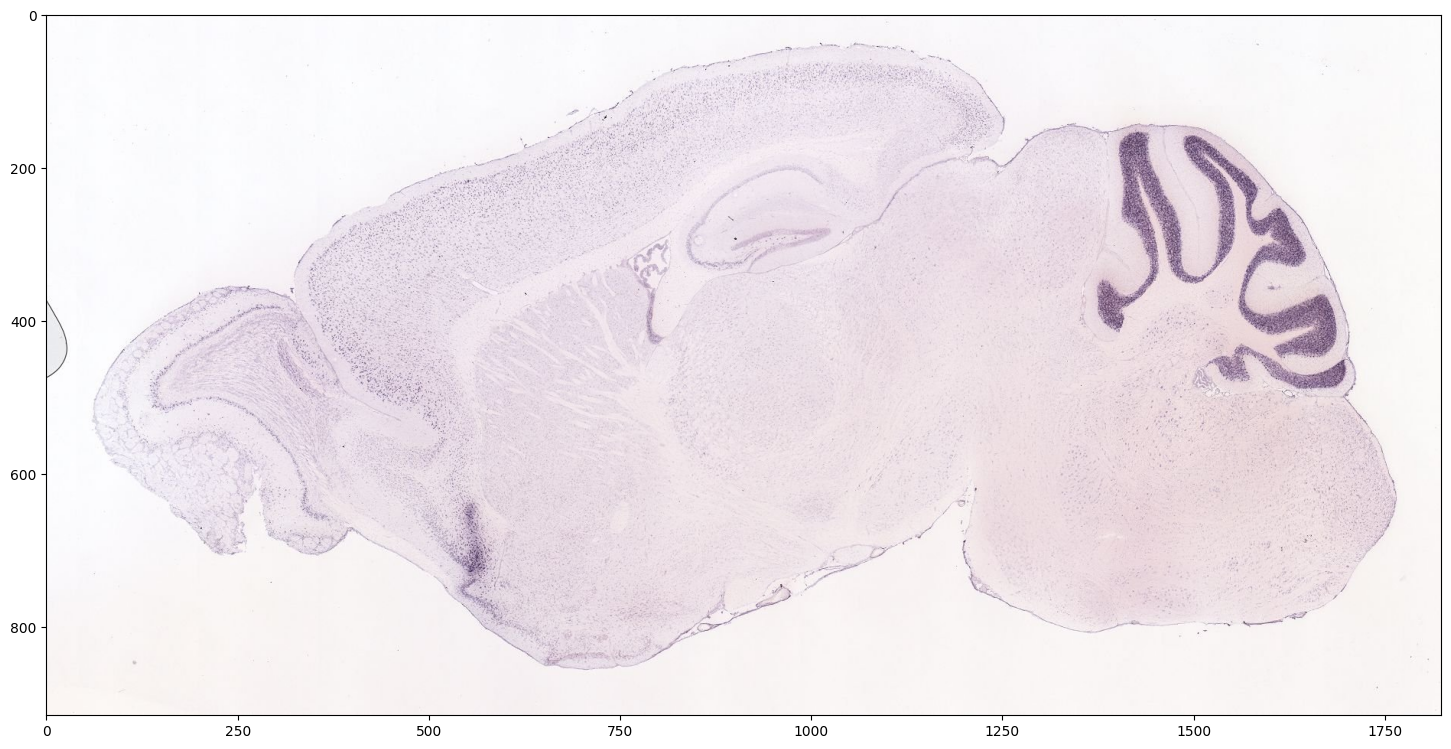

In [51]:
image_api.download_section_image(section_image_id, file_path, downsample=downsample)

verify_image(file_path)

### Downloading a single Mouse Connectivity image

In this example, we will download a single section image from <a href='http://connectivity.brain-map.org/projection/experiment/297225422'>Mouse Brain Connectivity experiment 297225422</a>. 

In [52]:
section_image_id = 297225716
file_path = Path(output_dir) / '297225716_connectivity.jpg'
downsample = 3

In order to clearly distinguish projection signal from background structure, it helps to window and rescale each channel. We have precomputed channelwise windows for each section data set in the connectivity atlas. You can obtain these window parameters using the `ImageDownloadApi`

In [53]:
ranges = image_api.get_section_image_ranges([section_image_id])[0]

Then simply pass them in via the `range` keyword argument.

2024-04-16 16:00:49,806 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/projection_image_download/297225716?downsample=3&range=0,825,0,943,0,4095


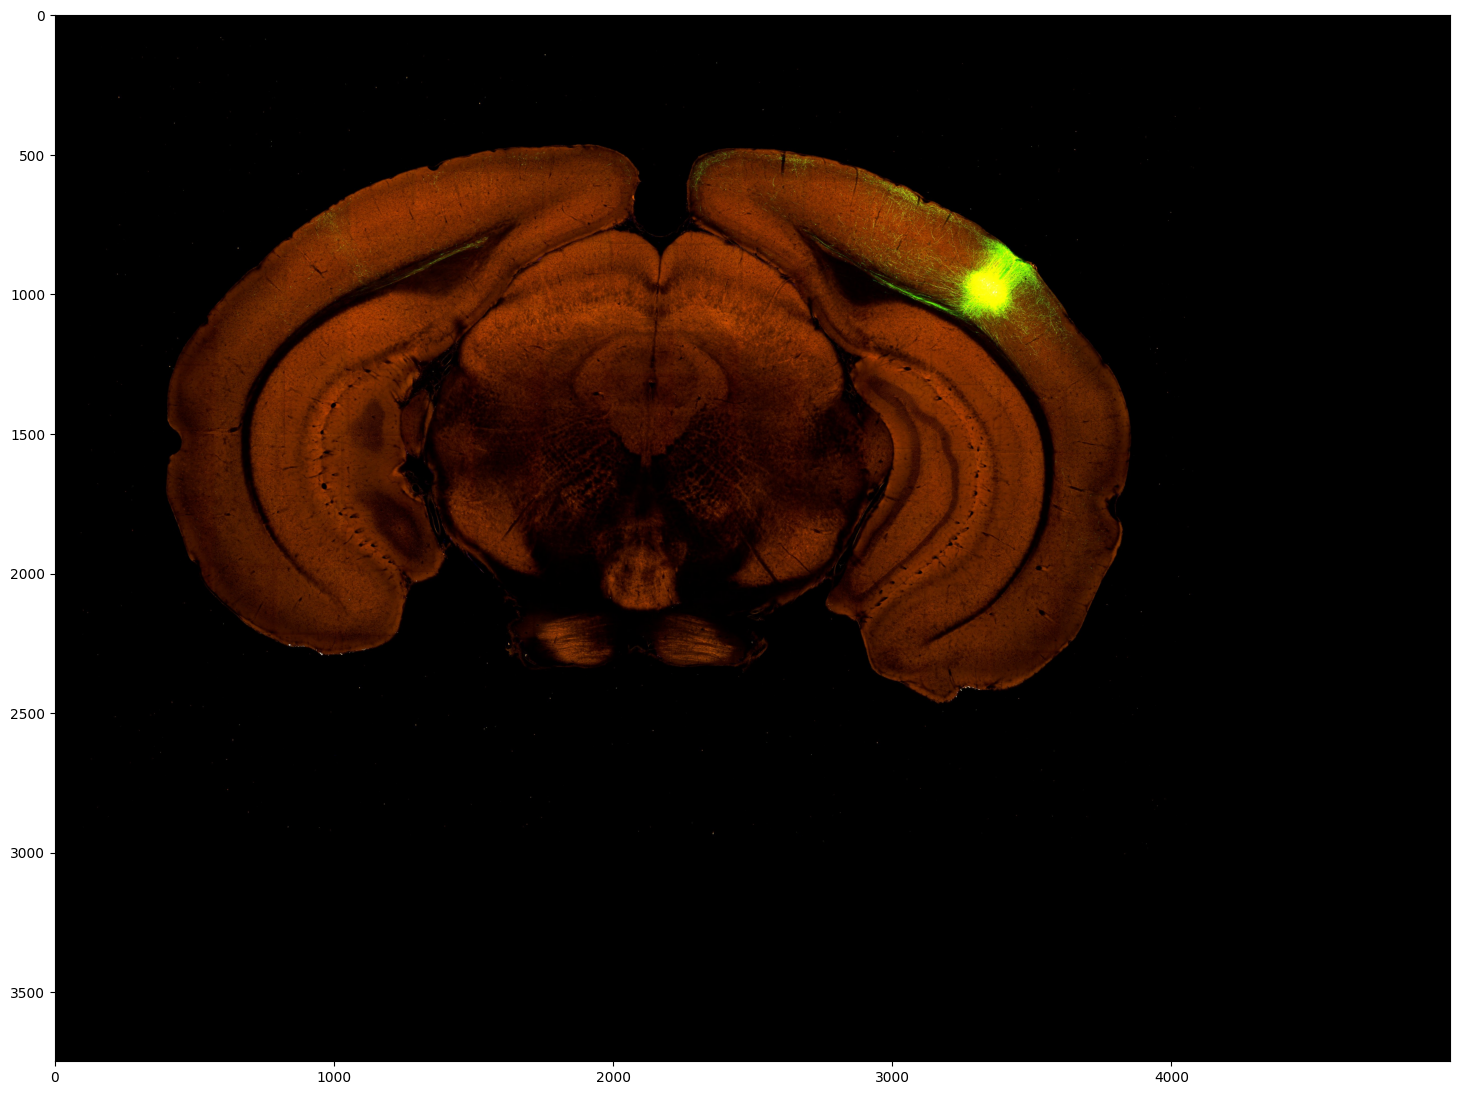

In [54]:
image_api.download_projection_image(section_image_id, file_path, downsample=downsample, range=ranges)

verify_image(file_path)

If we set the `projection` keyword argument to `True`, we can download a mask which labels important features of the image, such as the injection site, detected projection signal, and the boundary of detectable tissue.

2024-04-16 16:01:00,790 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/projection_image_download/297225716?downsample=3&projection=true


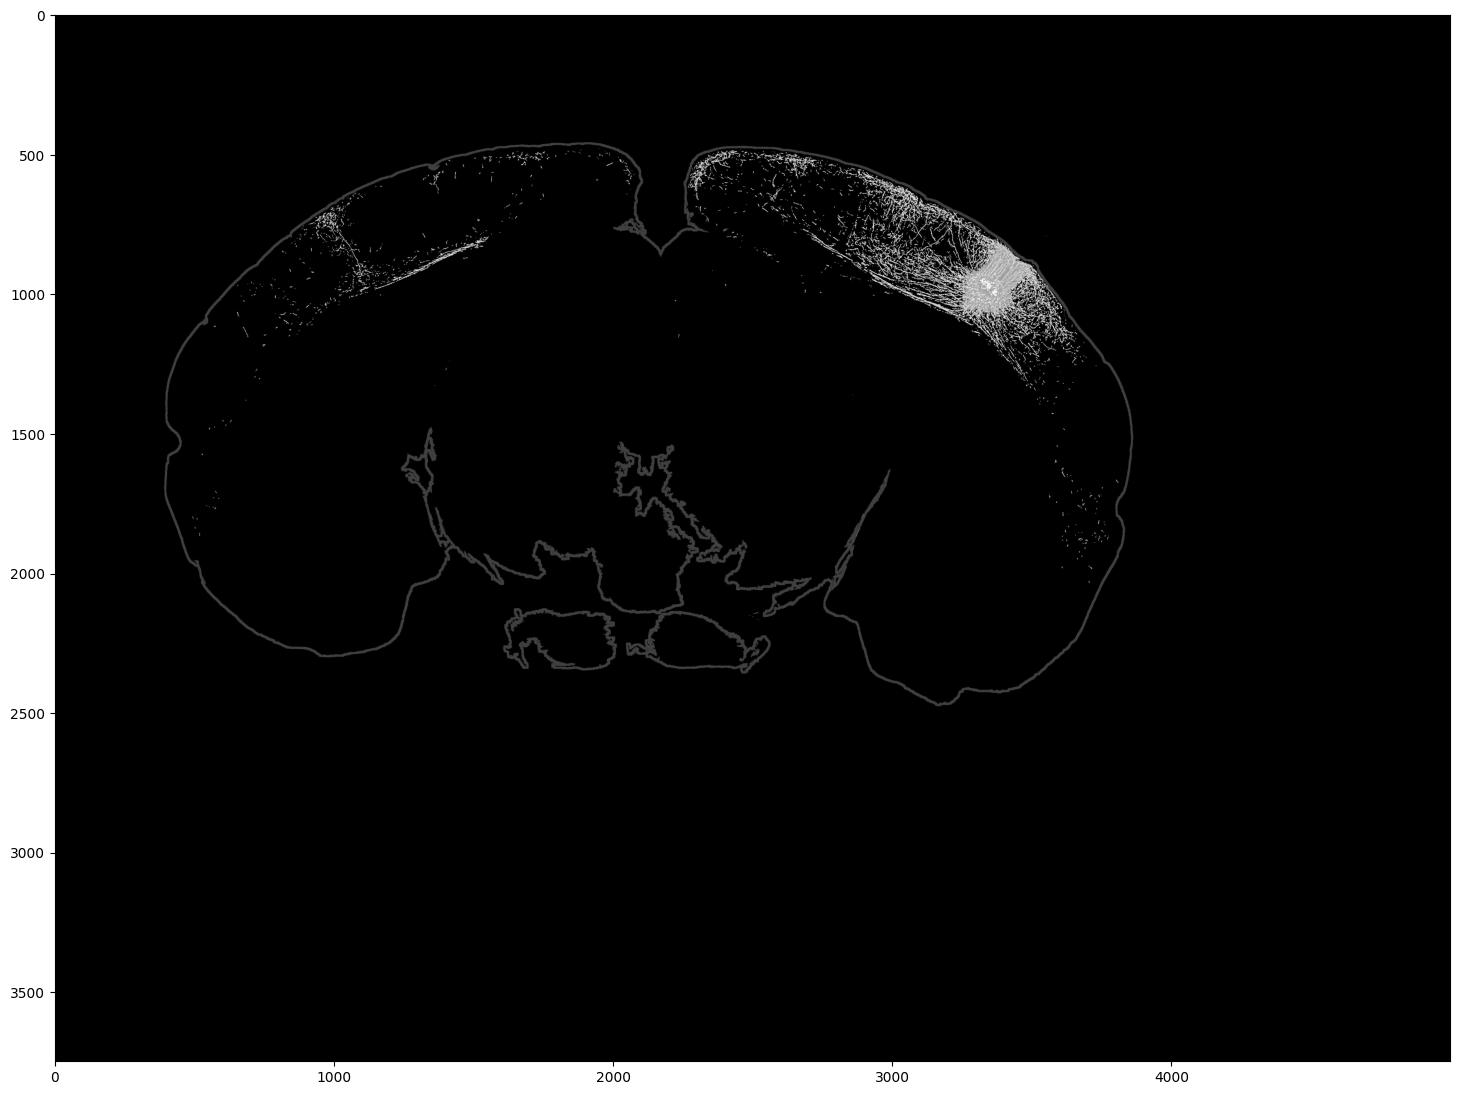

In [55]:
section_image_id = 297225716
file_path = Path(output_dir) / '297225716_projection.jpg'
downsample = 3
projection=True

image_api.download_projection_image(section_image_id, file_path, downsample=downsample, 
                                    projection=projection)

verify_image(file_path)

### Downloading a single atlas image

If we know the id of the atlas image we want, we can download it directly. We'll use an image from the <a href='http://atlas.brain-map.org/atlas?atlas=138322605'>Adult Human Brain Reference Atlas</a> for this example.

In [56]:
atlas_image_id = 112282603
downsample = 6
file_path = Path(output_dir) / '112282603_nissl.jpg'

Atlas images consist of an annotation image layered over a biological specimen image. You can control which one you download via the `annotation` keyword argument. 

Setting annotation to `False` will download the biological specimen (in this case, a Nissl section).

In [57]:
annotation = False

2024-04-16 16:01:12,493 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/atlas_image_download/112282603?downsample=6&annotation=false


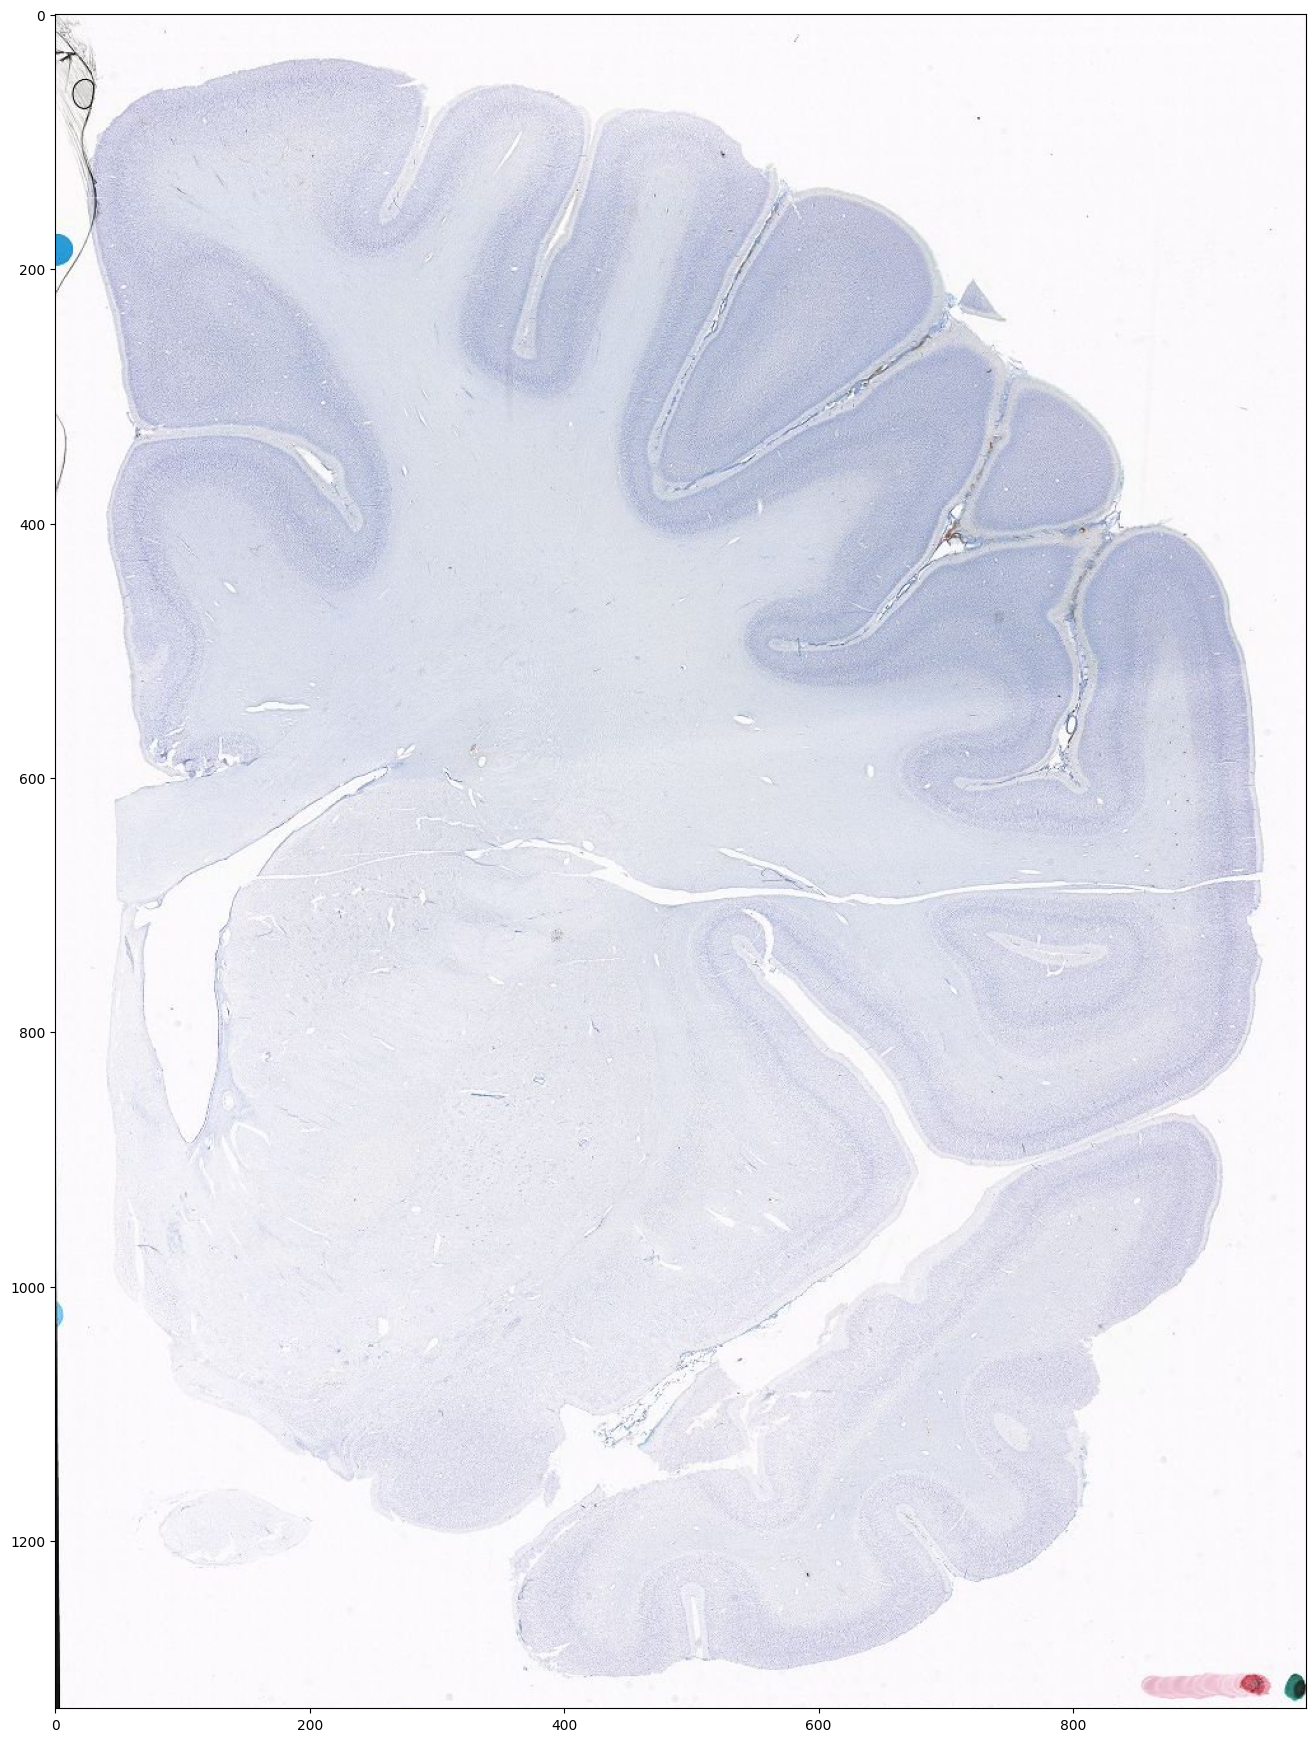

In [58]:
image_api.download_atlas_image(atlas_image_id, file_path, annotation=annotation, downsample=downsample)

verify_image(file_path)

We can download the structure drawings and labels (instead of the nissl) by setting annotation=True

2024-04-16 16:14:40,537 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/atlas_image_download/112360888?downsample=6&annotation=true


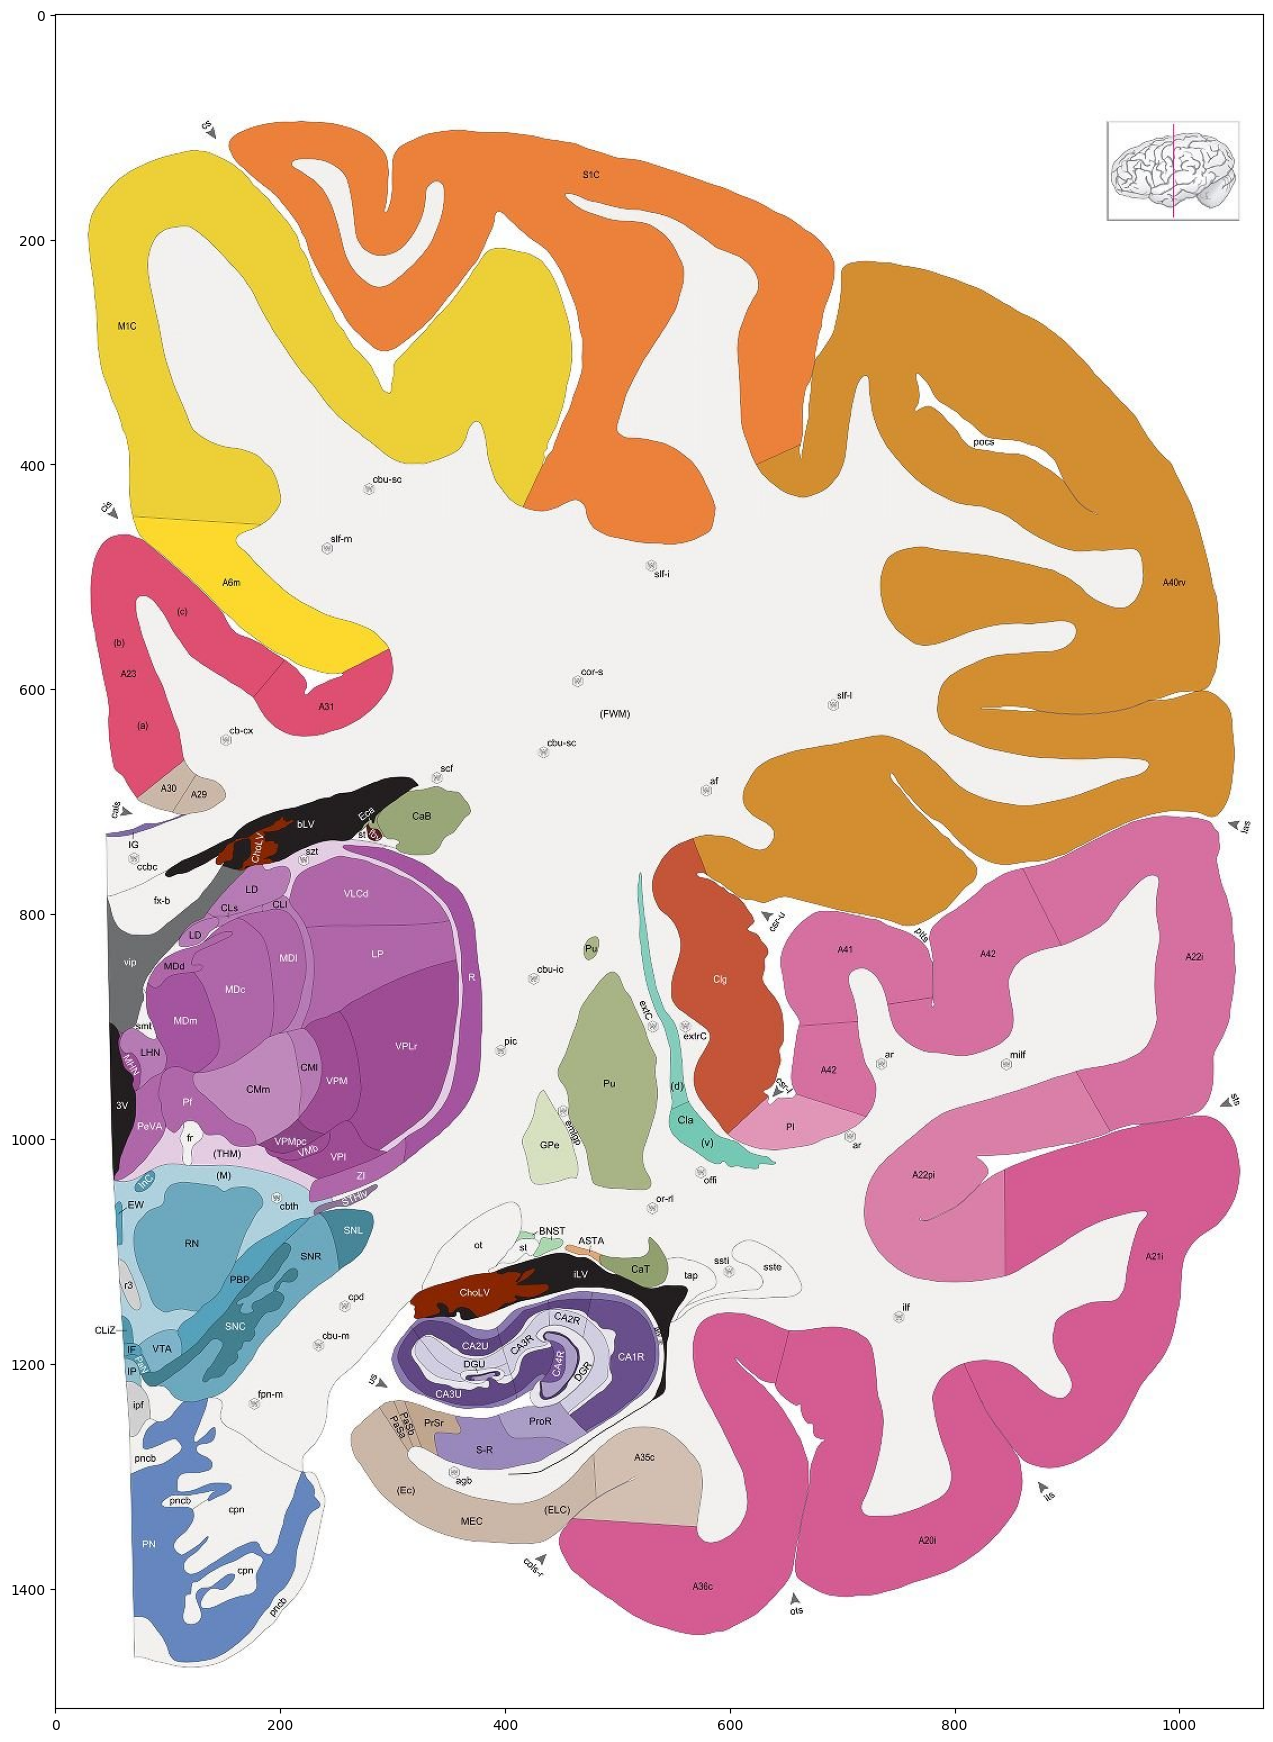

In [65]:
atlas_image_id = 112360888
annotation = True
downsample = 6
file_path = Path(output_dir) / '112360888_annotation.jpg'

image_api.download_atlas_image(atlas_image_id, file_path, annotation=annotation, downsample=downsample)
verify_image(file_path)

### Downloading a single atlas svg

We make the atlas drawings available (sans textual labels) as SVG. We'll download and display the SVG for the above atlas image:

In [17]:
from allensdk.api.queries.svg_api import SvgApi

svg_api = SvgApi()
svg_api.download_svg(atlas_image_id, file_path=Path(output_dir) / '112282603.svg')

2023-11-30 07:24:10,716 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/svg_download/112282603


In [18]:
verify_svg(Path(output_dir) / '112282603.svg', 35, 35)

### Listing images from an atlas (or section data set)

The `ImageDownloadApi` class can list the images in an atlas or section dataset. For an atlas (the same Human Brain reference atlas as above), this looks like:

In [19]:
atlas_id = 138322605

# image_api.section_image_query(section_data_set_id) is the analogous method for section data sets
atlas_image_records = image_api.atlas_image_query(atlas_id)

# this returns a list of dictionaries. Let's convert it to a pandas dataframe
atlas_image_dataframe = pd.DataFrame(atlas_image_records)

# and use the .head() method to display the first few rows
atlas_image_dataframe.head()

annotated  axes  bits_per_component  data_set_id expression  \
0       True  None                   8    100149965      False   
1       True  None                   8    100149965      False   
2       True  None                   8    100149965      False   
3       True  None                   8    100149965      False   
4       True  None                   8    100149965      False   

  expression_path  failed  height         id  image_height  ...  \
0            None   False   43392  102339919         47703  ...   
1            None   False   50176  102339937         53159  ...   
2            None   False   58080  102339949         58118  ...   
3            None   False   61824  102339958         61872  ...   
4            None   False   68447  102291506         68470  ...   

                                                path  projection_function  \
0  /external/devhuman/prod14/3760000240/376000024...                 None   
1  /external/devhuman/prod14/3760000257/376000025...                 None   
2  /external/devhuman/prod14/3760000274/376000027...                 None   
3  /external/devhuman/prod14/3760000289/376000028...                 None   
4  /external/devhuman/prod14/3760000363/376000036...                 None   

  resolution section_number  specimen_id structure_id tier_count  width     x  \
0      0.971            111         None        10155          9  29056  2176   
1      0.971            179         None        10155          9  36992  1280   
2      0.971            247         None        10155          9  49760     0   
3      0.971            307         None        10155          9  47904     0   
4      0.971            370         None        10155         10  49791     0   

      y  
0   896  
1  2816  
2     0  
3     0  
4     0  

[5 rows x 26 columns]

The `id` column of this dataframe contains the ids of the images in this atlas - these are the same integer identifiers that we have been using to download single images.

In [20]:
atlas_image_dataframe['id'].head()

0    102339919
1    102339937
2    102339949
3    102339958
4    102291506
Name: id, dtype: int64

### Downloading all of the images from a section data set

Specifically, <a href='http://www.brainspan.org/ish/experiment/show?id=100147602'>Brainspan ISH experiment 100147602</a>.

We'll start with some parameters:

In [21]:
section_data_set_id = 100147602
downsample=6

section_image_directory = Path(output_dir) / '75214738_section_images'
format_str = '.jpg'

Now we need to get the image ids for all of the images in this data set:

In [22]:
section_images = image_api.section_image_query(section_data_set_id)
section_image_ids = [si['id'] for si in section_images]

print(len(section_image_ids))

287


and then iterate:

In [23]:
# You have probably noticed that the AllenSDK has a logger which notifies you of file downloads. 
# Since we are downloading ~300 images, we don't want to see messages for each one.
# The following line will temporarily disable the download logger.
logging.getLogger('allensdk.api.api.retrieve_file_over_http').disabled = True

for section_image_id in section_image_ids:
    
    file_name = str(section_image_id) + format_str
    file_path = os.path.join(section_image_directory, file_name)
    
    Manifest.safe_make_parent_dirs(file_path)
    image_api.download_section_image(section_image_id, file_path=file_path, downsample=downsample)
    
# re-enable the logger
logging.getLogger('allensdk.api.api.retrieve_file_over_http').disabled = False

We should now have a directory containing the requested images.

In [24]:
file_names = os.listdir(section_image_directory)
print(len(file_names))

287


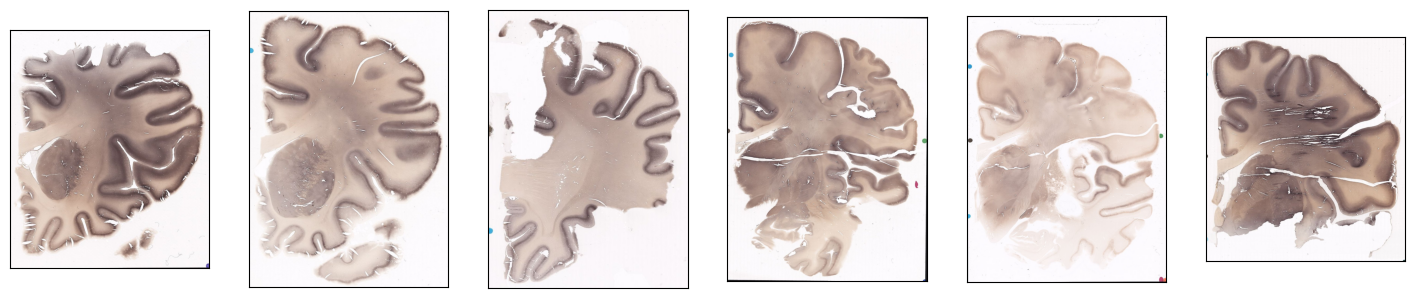

In [25]:
display_file_paths = [os.path.join(section_image_directory, dfn) for dfn in file_names[::50]]

fig, ax = plt.subplots(ncols=len(display_file_paths), figsize=(18, 22))
for ii, dfp in enumerate(display_file_paths):
    image = imread(dfp)
    ax[ii].imshow(image)
    ax[ii].get_xaxis().set_visible(False)
    ax[ii].get_yaxis().set_visible(False)

### Listing the section data sets in a product

Related experiments are grouped into [products](http://api.brain-map.org/api/v2/data/query.json?criteria=model::Product). The `ImageDownloadApi` has a method for listing the section data sets in a particular product. 

Here we will use this method to list section data sets from the Human Brain ISH SubCortex Study (id=10 per the above link).

In [26]:
human_subcortex_datasets = image_api.get_section_data_sets_by_product([10])

In [27]:
print('there are {} section data sets in the Human Brain ISH SubCortex Study'.format(len(human_subcortex_datasets)))

there are 519 section data sets in the Human Brain ISH SubCortex Study


In [28]:
pd.DataFrame(human_subcortex_datasets).head()

blue_channel  delegate  expression  failed  failed_facet green_channel  \
0         None     False        True   False     734881840          None   
1         None     False        True   False     734881840          None   
2         None     False        True   False     734881840          None   
3         None     False       False   False     734881840          None   
4         None     False       False   False     734881840          None   

          id  name  plane_of_section_id               qc_date red_channel  \
0  100095633  None                    1  2010-04-07T22:28:22Z        None   
1  100096379  None                    1  2010-04-21T14:26:24Z        None   
2  100096389  None                    1  2010-04-30T20:47:53Z        None   
3  100096377  None                    1  2010-10-14T16:05:06Z        None   
4  100096538  None                    1  2010-04-13T21:35:44Z        None   

  reference_space_id rnaseq_design_id  section_thickness  specimen_id  \
0               None             None               20.0       704498   
1               None             None               20.0       704522   
2               None             None               20.0       704521   
3               None             None               20.0       704521   
4               None             None               20.0       704624   

   sphinx_id storage_directory  weight  
0      79448              None    5240  
1      59229              None    5240  
2     163050              None    5240  
3      12900              None    5240  
4      46911              None    5240